<a href="https://colab.research.google.com/github/Pranav97Tyagi/linear-regression/blob/master/image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**NOTE- In Germany, the most common roof types are pitched roofs, specifically gable and hip roofs, followed by flat roofs**

Roof types:

Flat Roof – Minimal slope, common in commercial buildings.

Pitched Roof – Sloped surfaces, common in residential houses.

Gable Roof – Two sloped sides forming a triangular shape.

Dormer Roof: Subtype of Grable Roofs

Hip Roof – Slopes on all four sides.

Complex Roof – Irregular shapes with multiple slopes.

In [ ]:
# Library
import os
import pandas as pd
import numpy as np
import torch
import torchvision
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load image folder
root_dir = "/content/drive/My Drive/Colab Notebooks/"

In [ ]:
# path to labeled dataset
label_csv = os.path.join(root_dir, "labels.csv")
image_dir = os.path.join(root_dir, "images")
# training parameters
batch_sz = 32
n_classes = 6
epochs = 10
# Use GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Class for loading roof image and labels
class RoofImageDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        # Load the CSV file
        self.data = pd.read_csv(csv_path)
        # Store the path to the folder containing all the images
        self.img_dir = img_dir
        # Store the image transformation
        self.transform = transform

    def __len__(self):
        # Return the total number in the dataset
        return len(self.data)

    def __getitem__(self, index):
        # Create path using image folder and imagename from CSV
        filename = os.path.join(self.img_dir, self.data.iloc[index, 0])
        label = self.data.iloc[index, 1]
        label_index = label_to_index[label]

        # Open the image and convert it to RGB format
        image = Image.open(filename).convert("RGB")
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        # Return the transformed image and numeric values
        return image, label_index

In [ ]:
# Load the CSV file
data_df = pd.read_csv(label_csv)

# Extract and sort unique roof types
class_names = sorted(data_df['label'].unique())
# Mapping label to a unique index
label_to_index = {name: i for i, name in enumerate(class_names)}

# Reverse dictionary
index_to_label = {i: name for name, i in label_to_index.items()}

Neural networks understand numbers, we convert text labels to numbers using label_to_index before training, and convert predictions back to text using index_to_label during evaluation.

In [ ]:
# Prepare images for the neural network
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    # Convert images from PIL format to PyTorch tensors
    transforms.ToTensor(),
    # Normalize images
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# Load Labeled Data
roof_dataset = RoofImageDataset(label_csv, image_dir, transform=image_transforms)
roof_loader = DataLoader(roof_dataset, batch_size=batch_sz, shuffle=True)


# Load ResNet-34 Mode
cnn_model = models.resnet34(pretrained=True)
# Replace the fina layer to match the number of output classes (6)
cnn_model.fc = torch.nn.Linear(cnn_model.fc.in_features, n_classes)
# Use GPU if available, otherwise use CPU
cnn_model = cnn_model.to(device)


# Define the Loss Function
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizer to update model weights
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.0003)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 50.6MB/s]


In [ ]:
# Train the model
for epoch in range(epochs):
    # model to training mode
    cnn_model.train()
    # Initialize variables for los, correct, count
    total_loss, total_correct, total_samples = 0, 0, 0

    for imgs, lbls in roof_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        # Clear gradients
        optimizer.zero_grad()
        # Get predictions
        preds = cnn_model(imgs)
        # Calculate the loss between predictions and true labels
        loss = loss_fn(preds, lbls)
        loss.backward()
        optimizer.step()
        # Update running totals
        total_loss += loss.item()
        _, predicted = torch.max(preds.data, 1)
        total_samples += lbls.size(0)
        total_correct += (predicted == lbls).sum().item()
    # Print epoch summary
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {total_loss/len(roof_loader):.4f} - Accuracy: {100*total_correct/total_samples:.2f}%")


Epoch [1/10] - Loss: 1.8529 - Accuracy: 21.28%
Epoch [2/10] - Loss: 0.2362 - Accuracy: 100.00%
Epoch [3/10] - Loss: 0.1117 - Accuracy: 100.00%
Epoch [4/10] - Loss: 0.0315 - Accuracy: 100.00%
Epoch [5/10] - Loss: 0.0172 - Accuracy: 100.00%
Epoch [6/10] - Loss: 0.0276 - Accuracy: 100.00%
Epoch [7/10] - Loss: 0.0092 - Accuracy: 100.00%
Epoch [8/10] - Loss: 0.0051 - Accuracy: 100.00%
Epoch [9/10] - Loss: 0.0044 - Accuracy: 100.00%
Epoch [10/10] - Loss: 0.0029 - Accuracy: 100.00%


              precision    recall  f1-score   support

Complex Roof       1.00      1.00      1.00         3
 Dormer Roof       1.00      1.00      1.00         4
   Flat Roof       1.00      1.00      1.00        16
  Gable Roof       1.00      1.00      1.00         7
    Hip Roof       1.00      1.00      1.00         8
Pitched Roof       1.00      1.00      1.00         9

    accuracy                           1.00        47
   macro avg       1.00      1.00      1.00        47
weighted avg       1.00      1.00      1.00        47



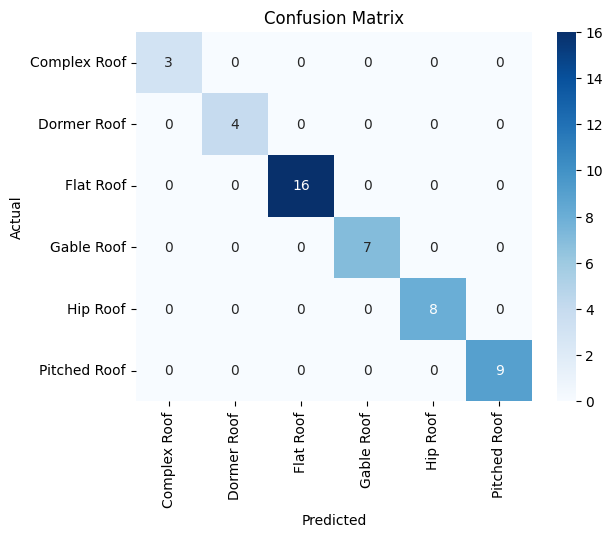

In [ ]:
# Set model to evaluation mode
cnn_model.eval()

# lists to collect true and predicted labels
y_true, y_pred = [], []

# Disable gradient calculations
with torch.no_grad():
    for imgs, lbls in roof_loader:
        # Move images and labels to GPU
        imgs, lbls = imgs.to(device), lbls.to(device)
        # Model predictions
        outputs = cnn_model(imgs)
        # Predicted class with highest score
        _, preds = torch.max(outputs, 1)
        # ave true and predicted labels
        y_true.extend(lbls.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Get sorted list of label indices
present_indices = sorted(set(y_true + y_pred))

# Map indices back to label names
present_names = [index_to_label[i] for i in present_indices]

# Print classification report
print(classification_report(y_true, y_pred,
                            labels=present_indices,
                            target_names=present_names,
                            zero_division=0))

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=present_indices)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', xticklabels=present_names,
            yticklabels=present_names,
            cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Save the trained model
torch.save(cnn_model.state_dict(), os.path.join(root_dir, "resnet34_roof_model.pth"))

In [ ]:
# Class for loading unlabeled roof image
class Unlabeled_Dataset(Dataset):
    def __init__(self, img_dir, transform=None):
        # directory containing the unlabeled images
        self.img_dir = img_dir
        # List all image files in the directory
        self.img_files = [f for f in os.listdir(img_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        # Store the image transformation
        self.transform = transform

    def __len__(self):
        # Return the total number of image files
        return len(self.img_files)

    def __getitem__(self, index):
        # Get the imagename at the given index
        filename = self.img_files[index]
        # Create the full file path
        path = os.path.join(self.img_dir, filename)
        # Convert it to RGB
        image = Image.open(path).convert("RGB")
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        # Return the processed image and original filename
        return image, filename

In [ ]:
# Path to the folder containing images
unlabeled_path = "/content/drive/MyDrive/Colab Notebooks/images"
# Create the dataset using Unlabeled_Dataset Classs
unlabeled_dataset = Unlabeled_Dataset(unlabeled_path, transform=image_transforms)
# Create a DataLoader to load images
loader = DataLoader(unlabeled_dataset, batch_size=1, shuffle=False)

# empty list to store predictions
predictions = []

# Model to evaluation mode
cnn_model.eval()
# Disable gradient computation
with torch.no_grad():
    for imgs, names in loader:
        # Move image tensor to GPU or CPU
        imgs = imgs.to(device)
        # pass through the model
        outputs = cnn_model(imgs)
        # Get the predicted class index
        _, pred_class = torch.max(outputs, 1)
        # Convert predicted index to label name
        label_name = index_to_label[pred_class.item()]
        # Append the predictions to list
        predictions.append((names[0], label_name))

In [ ]:
# DataFrame from the predictions list
pred_df = pd.DataFrame(predictions, columns=["Image", "Predicted Roof Type"])
# Save a CSV file
pred_df.to_csv("/content/drive/MyDrive/Colab Notebooks/unlabeled_predictions.csv", index=False)